# Process a BIOMASS L1 product on MAAP using the STAC API


**Important note:** To use this notebook, an account on ESA BIOMASS MAAP Product Algorithm Laboratory is required.

This tutorial is for users who are already familiar with STAC API and want to process data locally without explicit download or directly in the cloud. 
It is shown how to:
- Look for a product using the STAC API
- Use credentials to get an access token
- Open BIOMASS raster data lazily with rioxarray (rasterio+xarray) using file urls
- Make a valid PolSARpro dataset from these raster arrays
- Apply a polarimetric decomposition and save the result locally

### Prerequisites:
- Access to the collaborative environment https://portal.maap.eo.esa.int/biomass/initiative-membership/
- Credentials as described here https://portal.maap.eo.esa.int/ini/kb/books/enhanced-data-access/page/using-the-long-lasting-token-to-access-and-download-data 
- Pystac-client installed (`conda install pystac-client`)

This notebook may be run locally or in the MAAP coding environment. Installation of PyPolSARpro on the MAAP environment is described here: https://gist.github.com/odhondt/f9ce88acca5f91e8f3563b32a342addc

In [1]:
import requests
from pystac_client import Client
from pathlib import Path

URL_LANDING_PAGE = "https://catalog.maap.eo.esa.int/catalogue/"
api = Client.open(URL_LANDING_PAGE) # Connection to the catalog

## Search a product by ID using the STAC API
This step may be replaced by any valid STAC API query.
In the following, for the sake of demonstration, we only process the first product in the list.

In [2]:
ids = ["BIO_S2_SCS__1S_20251216T034800_20251216T034815_T_G01_M01_C02_T017_F289_01_DJQGAN"]

results = api.search(
    method = 'GET',   
    collections = 'BiomassLevel1a',
    ids = ids
)

In [3]:
items = results.item_collection()
# uncomment the following line to inspect item
# items[0]

In [4]:
# Extract urls of amplitude and phase rasters
url_abs = items[0].assets["enclosure_i_abs_tiff"].href
url_phase = items[0].assets["enclosure_i_phase_tiff"].href

## Request a token for product access
The code in the cell below was slightly adapted from: https://portal.maap.eo.esa.int/ini/kb/books/enhanced-data-access/page/using-the-long-lasting-token-to-access-and-download-data

In [5]:
def load_credentials(file_path):
    """Read key-value pairs from a credentials file into a dictionary."""
    creds = {}
    if not file_path.exists():
        raise FileNotFoundError(f"Credentials file not found: {file_path}")
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            if "=" not in line:
                continue
            key, value = line.split("=", 1)
            creds[key.strip()] = value.strip()
    return creds


def get_token(credential_file_path):
    """Use OFFLINE_TOKEN to fetch a short-lived access token."""
    creds = load_credentials(Path(credential_file_path))

    OFFLINE_TOKEN = creds.get("OFFLINE_TOKEN")
    CLIENT_ID = creds.get("CLIENT_ID")
    CLIENT_SECRET = creds.get("CLIENT_SECRET")

    if not all([OFFLINE_TOKEN, CLIENT_ID, CLIENT_SECRET]):
        raise ValueError("Missing OFFLINE_TOKEN, CLIENT_ID, or CLIENT_SECRET in credentials file")

    url = "https://iam.maap.eo.esa.int/realms/esa-maap/protocol/openid-connect/token"
    data = {
        "client_id": CLIENT_ID,
        "client_secret": CLIENT_SECRET,
        "grant_type": "refresh_token",
        "refresh_token": OFFLINE_TOKEN,
        "scope": "offline_access openid"
    }

    response = requests.post(url, data=data)
    response.raise_for_status()

    response_json = response.json()
    access_token = response_json.get('access_token')

    if not access_token:
        raise RuntimeError("Failed to retrieve access token from IAM response")

    return access_token

## Access product raster and process on-the-fly
Requisite: create a credential file as described here https://portal.maap.eo.esa.int/ini/kb/books/enhanced-data-access/page/using-the-long-lasting-token-to-access-and-download-data 

In [6]:
# Authentication
token = get_token("/data/credentials.txt")

In [7]:
import rioxarray as riox
import rasterio as rio

# Datasets lazy loading
with rio.Env(
    GDAL_HTTP_HEADERS=f"Authorization: Bearer {token}",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    GDAL_NUM_THREADS="ALL_CPUS",
):
    da_abs = riox.open_rasterio(url_abs, chunks={})
    da_phase = riox.open_rasterio(url_phase, chunks={})

In [8]:
import numpy as np
import xarray as xr

# Reconstruct SLC images
slc = da_abs * np.exp(1j * da_phase)
dims = ("y", "x")
# Extract polSAR channels and create a PolSARpro S matrix
S = xr.Dataset(
    {
        "hh": (dims, slc[0].data),
        "hv": (dims, slc[1].data),
        "vh": (dims, slc[2].data),
        "vv": (dims, slc[3].data),
    },
    coords={"y": np.arange(slc.shape[1]), "x": np.arange(slc.shape[2])},
    attrs={"poltype": "S", "description": "Scattering matrix"},
).chunk("auto")

## Process with (Py)PolSARpro

In [9]:
from polsarpro.decompositions import freeman
from dask.diagnostics import ProgressBar
import os

out_file = "/data/psp/res/freeman_biomass.nc"
if os.path.exists(out_file):
    os.remove(out_file)

with ProgressBar():
    freeman(S, [7, 7]).to_netcdf(out_file)

[########################################] | 100% Completed | 36.01 s


## Visualize the results

In [10]:
out_file = "/data/psp/res/freeman_biomass.nc"
out = xr.open_dataset(out_file)

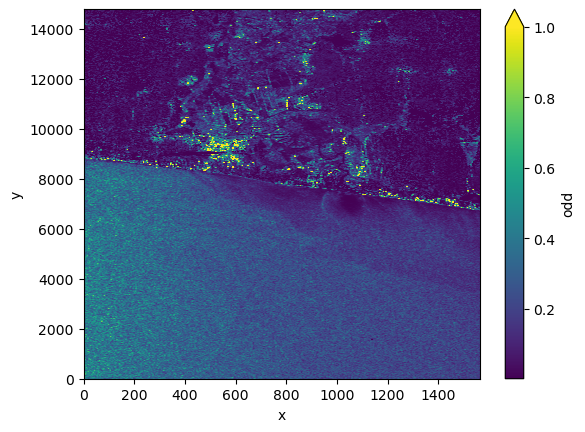

In [11]:
out.odd.plot.imshow(vmax=1)

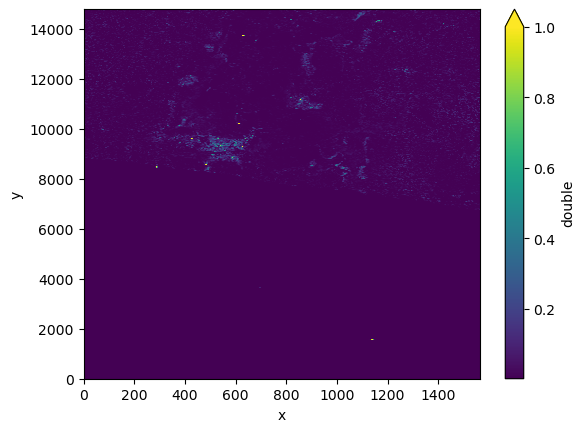

In [12]:
out.double.plot.imshow(vmax=1)

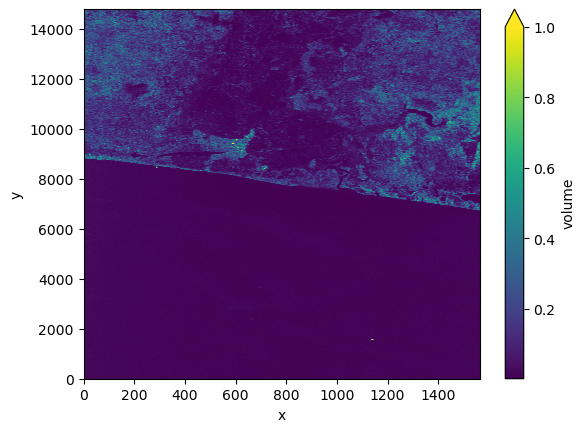

In [13]:
out.volume.plot.imshow(vmax=1)